<a href="https://colab.research.google.com/github/aridil/lung_cancer_classification/blob/main/Projet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CLASSIFICATION OF CHEST CT-SCAN IMAGES**

---
by Idil Ari

# 1 - Import et récupération dataset
download du dataset depuis Kaggle


In [ ]:
import numpy as np
import os
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt

from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D

from sklearn.metrics import confusion_matrix #, plot_confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d mohamedhanyyy/chest-ctscan-images -p /content/kaggle/

chest-ctscan-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip kaggle/chest-ctscan-images.zip -d kaggle

Archive:  kaggle/chest-ctscan-images.zip
replace kaggle/Data/test/adenocarcinoma/000108 (3).png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# 2 - Préprocessing dataset


> La préparation des dataset est une étape très importante




### 2.1 - Train, test et validation dataset

Grâce à la fonction keras (tf.keras.utils.image_dataset_from_directory), on va aller extraire les images des différents dossiers importés depuis Kaggle et les placer dans les différents ensembles de données (train, test et valid). En plus de cela, la fonction va garder la structure du dossier pour classifier les images: les noms des sous-dossiers sont repris pour les noms des classes (grâce à *labels = 'inferred'*). 

Il est important d'avoir la même taille pour toutes les images et de les batcher (en effet envoyer les images une par une prendrait trop de temps c'est pourquoi on les regroupe par paquet). Ceci va également être pris en charge par la fonction keras utilisée, en précisant bien les paramètres souhaités.


Ce que nous renvoie cette fonction keras est un dataset (un object  tf.data.Dataset), c'est-à-dire un tuple (images, labels). L'image sera de forme (batch_size, image_size[0], image_size[1], num_channels).

ref: https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

In [ ]:
# créer les ensembles de données 

batch_size = 32         #default value
img_height =227         # 256 by default value
img_width =227          # 256 default value
train_ds = tf.keras.utils.image_dataset_from_directory( "/content/kaggle/Data/train", labels = 'inferred', label_mode = 'int', image_size=(img_height, img_width),   batch_size=batch_size)
test_ds = tf.keras.utils.image_dataset_from_directory( "/content/kaggle/Data/test", labels = 'inferred', label_mode = 'int', image_size=(img_height, img_width),   batch_size=batch_size)
valid_ds = tf.keras.utils.image_dataset_from_directory( "/content/kaggle/Data/valid", labels = 'inferred', label_mode = 'int', image_size=(img_height, img_width),   batch_size=batch_size)


Found 613 files belonging to 4 classes.
Found 315 files belonging to 4 classes.
Found 72 files belonging to 4 classes.


In [ ]:
#trouver les noms de classe dans l'attribut class_names

class_names = valid_ds.class_names
print(class_names)
#class_names = ['adenocarcinoma', 'large cell carcinoma', 'normal', 'squamous cell carcinoma']

['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']


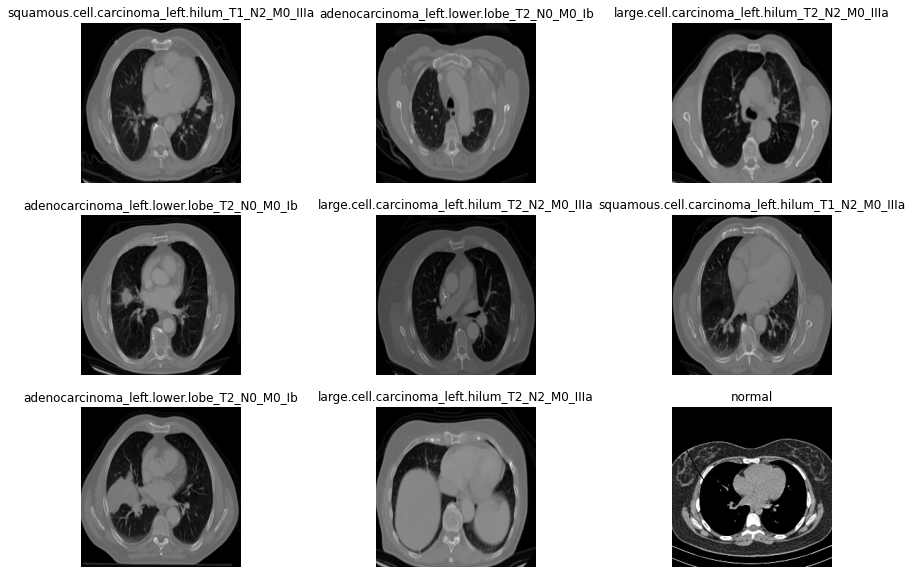

In [ ]:
# visualiser les images du premier jeu de données

plt.figure(figsize=(15, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

# image_batch = tenseur de la forme (32, 227, 227, 3) : groupe de 32 images de forme 227x227x3 (la dernière dimension correspond aux canaux de couleur RVB)
# label_batch = tenseur de la forme (32,) : ce sont des labels (donc les classes) correspondants aux 32 images (notation numpy d'un scalaire)

(32, 227, 227, 3)
(32,)


###2.2 - Data augmentation

utiliser la data augmentation pour améliorer les différences de nos images dans notre dataset
cela va changer les variances et différences des images

ref : https://www.youtube.com/watch?v=q0_avC6cPMY 

In [ ]:
#data augmentation 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32 
img_size = 227

train_datagen = ImageDataGenerator(
        #rescale=1./255,             à décommander si on veut afficher les images
        rotation_range = 20,  
        width_shift_range = 0.1, 
        height_shift_range = 0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# rescaling pas nécessaire car va se faire à la première couche du réseau
test_datagen = ImageDataGenerator()
valid_datagen = ImageDataGenerator()

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'kaggle/Data/train',  
        target_size=(img_size, img_size), 
        batch_size=batch_size,
        class_mode = 'sparse')  

valid_generator = valid_datagen.flow_from_directory(
        'kaggle/Data/valid',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode = 'sparse')

test_generator = test_datagen.flow_from_directory(
        'kaggle/Data/test',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode = 'sparse')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [ ]:
imgs, labels = next(train_generator)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

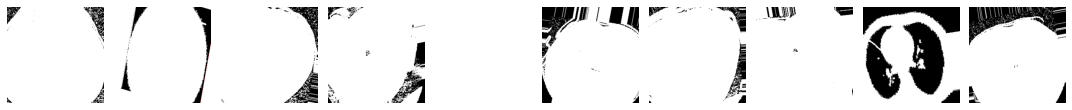

[0. 2. 3. 0. 2. 1. 0. 3. 2. 1. 0. 3. 2. 1. 2. 1. 0. 0. 1. 3. 3. 2. 0. 3.
 0. 0. 0. 2. 0. 1. 2. 2.]


In [ ]:
fig, axes = plt.subplots(1,10, figsize = (15,10))
for img, ax in zip(imgs, axes):
  ax.imshow(img)
  ax.axis('off')

plt.tight_layout()
plt.show()
print(labels)

###2.3 - Normalisation 


La normalisation est nécessaire car dans un réseau neuronal on cherche à avoir des valeurs d'entrée assez petites. Ici on divise par 255 car on a des images RVB et donc des valeurs allant de 0 à 255. On va ramener ces valeurs entre 0 et 1.

A savoir, on peut normaliser directement dans le modèle en placant le *layers.Rescaling(1./255)* à la premère couche.

In [32]:
# Normalizing the image to [0,1] range

normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))


first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


# 3 - Création du model

Le modèle utilisé est un **Sequential** modèle où l'on va simplement empiler des couches qui ont exactement un tenseur d'entrée et un de sortie.

Le modèle Sequential est utilisé ici en faisant passer au constructeur une liste de couches accessibles via les layers attribut. On va procéder à une suite de couches de convolution suivies de pooling et finir par une couche de flatten:


*   Conv2D(): va permettre de trouver les filtres qui vont bien correspondre pour décrire l'image
*   MaxPooling2D(): réduire l'image pour au final avoir un jeu de donnée qu'on va envoyer à notre réseau dense, de plus en plus petit et de plus en plus concaténer pour représenter au maximum les features les plus petites -> va prendre le maximumun du pooling
*   Flatten(): va permettre de construire un vecteur à partir de notre matrice 




Une fois le modèle créé, on peut afficher son résumé grâce à *summary()*.

In [ ]:
# create model
# entraîner un modèle à l'aide de ces jeux de données en les transmettant à model.fit

num_classes = len(class_names)    #ici 4

model = Sequential([ 
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(64, 3, activation='relu'),                                      #(filters,kernel_size,activation)
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')                               #pour avoir la proba entre les différentes classes
])


In [ ]:
model.compile(
  optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
model.summary() # afficher le contenu d'un modèle

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 227, 227, 3)       0         
                                                                 
 conv2d_33 (Conv2D)          (None, 225, 225, 64)      1792      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 110, 110, 32)      18464     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 55, 55, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 53, 53, 32)       

# 4 - Entraîner le modèle

In [ ]:
# checker si le GPU est enabled

tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs= 30
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


20/20 [==============================] - 3s 115ms/step - loss: 1.1561 - accuracy: 0.4617 - val_loss: 0.8830 - val_accuracy: 0.6389
Epoch 2/30
20/20 [==============================] - 3s 106ms/step - loss: 0.7302 - accuracy: 0.6949 - val_loss: 0.8187 - val_accuracy: 0.6250
Epoch 3/30
20/20 [==============================] - 3s 106ms/step - loss: 0.4831 - accuracy: 0.8108 - val_loss: 0.7364 - val_accuracy: 0.6389
Epoch 4/30
20/20 [==============================] - 3s 108ms/step - loss: 0.3065 - accuracy: 0.8842 - val_loss: 0.8171 - val_accuracy: 0.6944
Epoch 5/30
20/20 [==============================] - 3s 108ms/step - loss: 0.1526 - accuracy: 0.9511 - val_loss: 0.5957 - val_accuracy: 0.7917
Epoch 6/30
20/20 [==============================] - 3s 106ms/step - loss: 0.1004 - accuracy: 0.9674 - val_loss: 0.6382 - val_accuracy: 0.7778
Epoch 7/30
20/20 [==============================] - 3s 108ms/step - loss: 0.0824 - accuracy: 0.9821 - val_loss: 0.5467 - val_accuracy: 0.8333
Epoch 8/30
20/20 

# 5 - Evaluation and Predict 

### 5.1 - Training history

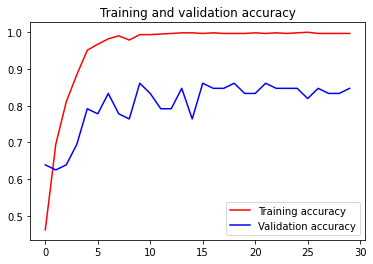

<Figure size 432x288 with 0 Axes>

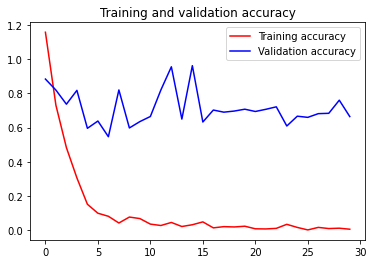

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

plt.plot(epochs, loss, 'r', label='Training accuracy')
plt.plot(epochs, val_loss, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

### 5.2 - Model evaluate

In [ ]:
score = model.evaluate(test_ds, verbose=0)

print('loss_data_augm         : {:5.4f}'.format(score[0]))
print('acccuracy_data_augm    : {:5.4f}'.format(score[1]))

loss_data_augm         : 3.8252
acccuracy_data_augm    : 0.4540


In [ ]:
model.save('content')

### 5.3 - Prediction

In [ ]:
predictions = model.predict(test_ds, batch_size, verbose=0)
rounded_predictions = np.argmax(predictions, axis = -1)  #normaliser

print(rounded_predictions)
print(len(rounded_predictions))

[1 1 2 3 3 3 1 1 1 1 2 2 1 1 1 1 0 1 1 1 1 2 1 2 3 3 0 2 1 1 2 1 1 1 2 3 3
 3 1 1 1 1 1 2 1 1 2 2 1 1 1 1 2 1 2 2 1 1 1 2 1 1 0 0 1 1 1 1 0 2 1 2 0 2
 3 2 2 2 1 2 1 1 2 3 1 3 3 1 3 1 2 1 2 1 1 3 2 3 2 2 2 1 1 1 2 2 3 2 2 1 1
 1 1 1 1 1 2 3 1 0 1 1 1 0 1 3 1 2 2 3 2 1 1 1 1 1 2 1 1 1 1 3 2 3 1 1 1 1
 1 1 1 2 1 2 1 1 3 1 1 0 1 1 1 1 1 2 1 3 1 0 0 2 1 1 2 1 3 1 1 2 1 2 2 0 2
 3 0 1 1 2 2 2 1 1 1 1 1 1 1 0 0 1 2 1 1 1 1 1 1 0 1 2 0 1 3 1 1 1 1 2 1 1
 1 1 2 1 1 1 2 0 2 3 1 2 3 1 1 3 0 1 2 0 1 2 2 1 1 3 2 2 0 2 3 1 2 2 1 1 1
 3 1 1 2 1 1 1 2 3 1 1 1 1 3 1 1 1 3 3 2 2 1 1 2 1 1 1 2 1 1 1 0 2 1 1 3 3
 2 3 3 1 3 1 1 2 1 2 1 2 1 1 1 2 1 2 1]
315


### Confusion matrix

La matrice de confusion permet une meilleure visualisation de la prédiction.
Elle permet aussi d'observer l'erreur sur le classification des images.


code from: https://deeplizard.com/learn/video/km7pxKy4UHU

In [ ]:
y_test = []
for images, labels in test_ds:
  labels = np.array(labels)
  for i in labels: 
    y_test.append(i) 

y_test = np.transpose(y_test)

[[ 5 78 23 14]
 [ 4 24 14  9]
 [ 3 29 16  6]
 [10 42 26 12]]


Text(0.5, -17.873629022556997, 'Predicted label')

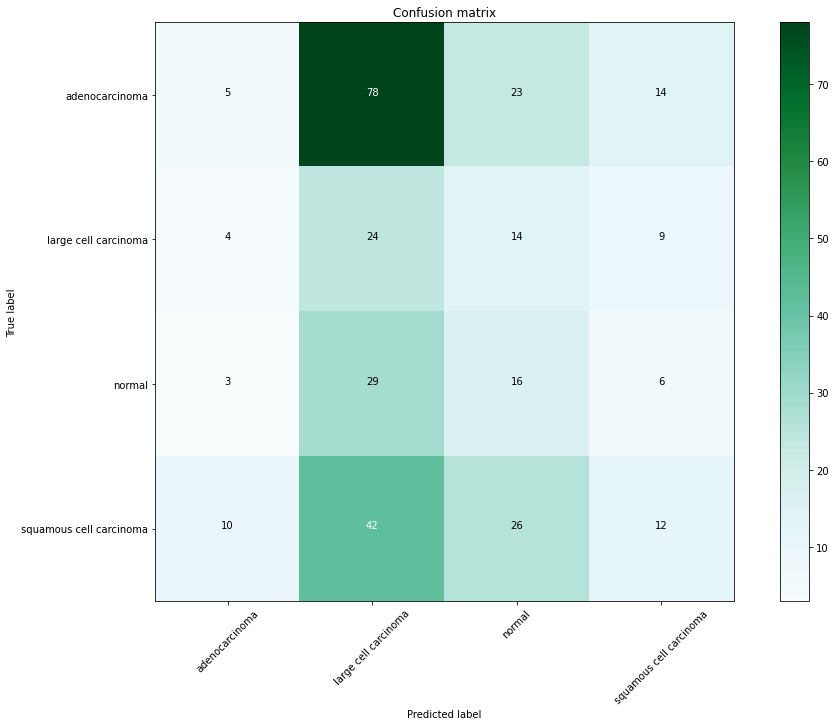

In [ ]:
from mlxtend.plotting import plot_confusion_matrix

cm_plot_labels = ['adenocarcinoma', 'large cell carcinoma', 'normal', 'squamous cell carcinoma']
cm = confusion_matrix(y_true= y_test, y_pred=rounded_predictions)

plt.figure(figsize=(14, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.BuGn)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(cm_plot_labels))
plt.xticks(tick_marks, cm_plot_labels, rotation=45)
plt.yticks(tick_marks, cm_plot_labels)

print(cm)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')



#plot_confusion_matrix(cm, cm_plot_labels)



---



# 6 - Entrainer le modèle avec Data Augmentation

## 6.1 - Entrainer le modèle avec data augmentation

In [ ]:
# create model
# entraîner un modèle à l'aide de ces jeux de données en les transmettant à model.fit

num_classes = len(class_names)    #ici 4

model2 = Sequential([ layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')   #pour avoir la proba entre les différentes classes
])



In [ ]:
model2.compile(
  optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
model2.summary() # afficher le contenu d'un modèle

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 127, 127, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 60, 60, 32)       

In [ ]:
history_data_aug = model2.fit(
  train_generator,
  validation_data=valid_generator,
  epochs= 50
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


20/20 [==============================] - 10s 480ms/step - loss: 1.3420 - accuracy: 0.3197 - val_loss: 1.4152 - val_accuracy: 0.2639
Epoch 2/50
20/20 [==============================] - 9s 449ms/step - loss: 1.2782 - accuracy: 0.3638 - val_loss: 1.3130 - val_accuracy: 0.3750
Epoch 3/50
20/20 [==============================] - 9s 452ms/step - loss: 1.2066 - accuracy: 0.4372 - val_loss: 1.2795 - val_accuracy: 0.4167
Epoch 4/50
20/20 [==============================] - 10s 478ms/step - loss: 1.1526 - accuracy: 0.4731 - val_loss: 1.1374 - val_accuracy: 0.4861
Epoch 5/50
20/20 [==============================] - 9s 448ms/step - loss: 1.0947 - accuracy: 0.4861 - val_loss: 1.0512 - val_accuracy: 0.4722
Epoch 6/50
20/20 [==============================] - 9s 447ms/step - loss: 1.0709 - accuracy: 0.5237 - val_loss: 1.0685 - val_accuracy: 0.4444
Epoch 7/50
20/20 [==============================] - 9s 446ms/step - loss: 0.9833 - accuracy: 0.5285 - val_loss: 1.0283 - val_accuracy: 0.4583
Epoch 8/50
20/2

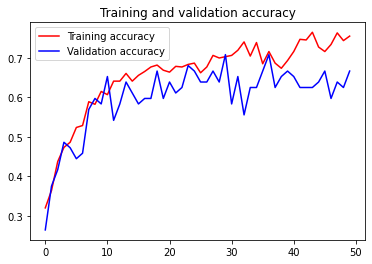

<Figure size 432x288 with 0 Axes>

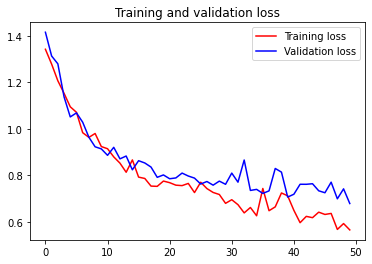

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history_data_aug.history['accuracy']
val_acc = history_data_aug.history['val_accuracy']
loss = history_data_aug.history['loss']
val_loss = history_data_aug.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

##6.2 - Evaluer le modèle avec data augmentation 

In [ ]:
score_aug = model2.evaluate(test_ds, verbose=0)

print('loss_aug         : {:5.4f}'.format(score_aug[0]))
print('acccuracy_aug    : {:5.4f}'.format(score_aug[1]))

loss_aug         : 1.1759
acccuracy_aug    : 0.5556


[[17 50 25 28]
 [11 17 16  7]
 [ 9 22 13 10]
 [21 30 14 25]]


Text(0.5, -17.873629022556997, 'Predicted label')

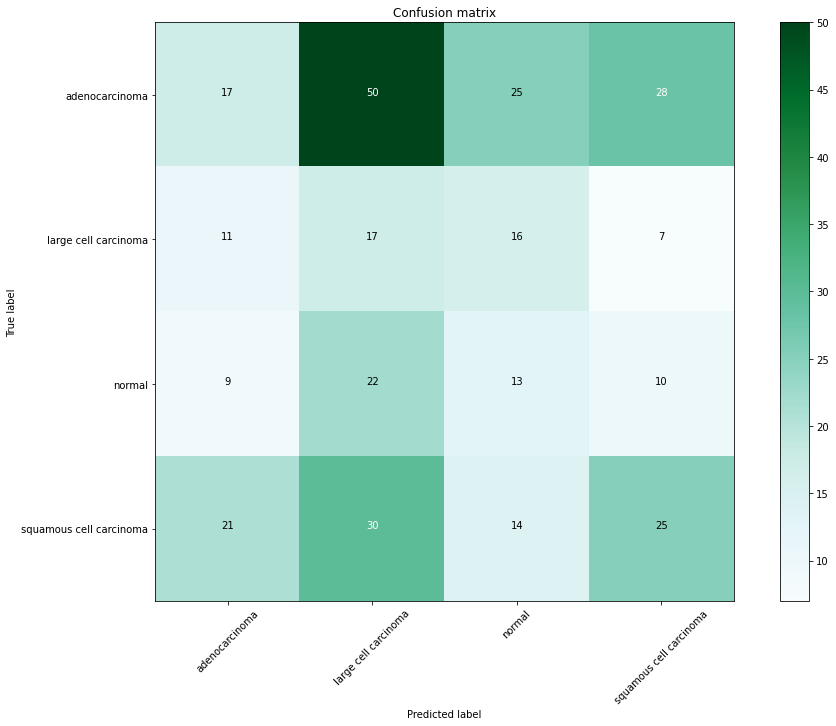

In [ ]:
from mlxtend.plotting import plot_confusion_matrix

predictions = model2.predict(test_ds, batch_size, verbose=0)
rounded_predictions_al = np.argmax(predictions, axis = -1)  #normaliser

y_test_al = []
for images, labels in test_ds:
  labels = np.array(labels)
  for i in labels: 
    y_test_al.append(i) 

y_test_al = np.transpose(y_test_al)

cm_plot_labels = ['adenocarcinoma', 'large cell carcinoma', 'normal', 'squamous cell carcinoma']
cm = confusion_matrix(y_true= y_test_al, y_pred=rounded_predictions_al)

plt.figure(figsize=(14, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.BuGn)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(cm_plot_labels))
plt.xticks(tick_marks, cm_plot_labels, rotation=45)
plt.yticks(tick_marks, cm_plot_labels)

print(cm)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')



---


# 7 - Entrainer le modèle AlexNet

architecture de base trouvée dans 
https://doi.org/10.1016/j.bbe.2019.11.004

## 7.1 - Entrainer AlexNet (ici denier entrainement avec data augmentation)

In [ ]:
# Building ALEXNET model

#num_classes = len(class_names)    #ici 4

model_alexnet = Sequential([ 
  layers.Rescaling(1./255, input_shape=(227, 227, 3)),
  layers.Conv2D(96, 11, strides=(4, 4), activation='relu'), 
  layers.MaxPooling2D(pool_size =(3, 3),strides=(2, 2)),
  layers.Conv2D(256, 5, padding="same", activation='relu'),
  layers.MaxPooling2D(  strides=(2, 2)),
  layers.Conv2D(384, 3,padding="same", activation='relu'),
  layers.Conv2D(384, 3,padding="same", activation='relu'),
  layers.Conv2D(256, 3,padding="same",activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size =(3, 3), strides=(2, 2)),
  layers.Flatten(),                                                             
  layers.Dense(4096, activation='relu'),
  layers.Dense(4096, activation='relu'),
  layers.Dense(1000, activation='relu'),
  layers.Dense(4, activation='softmax')                                          #pour avoir la proba entre les différentes classes
])

model_alexnet.compile(
  optimizer='sgd',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
model_alexnet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 227, 227, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 256)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 384)      

In [ ]:
history_alex= model_alexnet.fit(
  train_generator,
  validation_data=valid_ds,
  epochs= 80
)

Epoch 1/70


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


20/20 [==============================] - 10s 457ms/step - loss: 1.2992 - accuracy: 0.4307 - val_loss: 1.3856 - val_accuracy: 0.1806
Epoch 2/70
20/20 [==============================] - 11s 550ms/step - loss: 1.0779 - accuracy: 0.5090 - val_loss: 1.3521 - val_accuracy: 0.4861
Epoch 3/70
20/20 [==============================] - 14s 707ms/step - loss: 1.0197 - accuracy: 0.5514 - val_loss: 1.3487 - val_accuracy: 0.5139
Epoch 4/70
20/20 [==============================] - 9s 434ms/step - loss: 0.9212 - accuracy: 0.5856 - val_loss: 1.3307 - val_accuracy: 0.4444
Epoch 5/70
20/20 [==============================] - 9s 437ms/step - loss: 0.9354 - accuracy: 0.5759 - val_loss: 1.3496 - val_accuracy: 0.2222
Epoch 6/70
20/20 [==============================] - 9s 452ms/step - loss: 0.9594 - accuracy: 0.5693 - val_loss: 1.3295 - val_accuracy: 0.5000
Epoch 7/70
20/20 [==============================] - 9s 436ms/step - loss: 0.8767 - accuracy: 0.6248 - val_loss: 1.2746 - val_accuracy: 0.4583
Epoch 8/70
20/

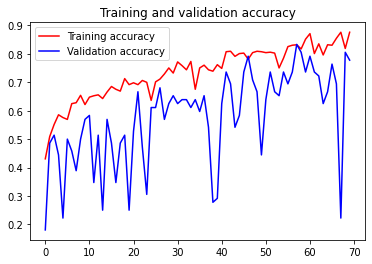

<Figure size 432x288 with 0 Axes>

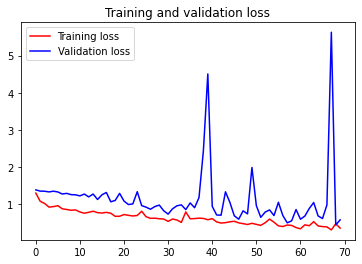

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history_alex.history['accuracy']
val_acc = history_alex.history['val_accuracy']
loss = history_alex.history['loss']
val_loss = history_alex.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
model_alexnet.save('kaggle/model')

INFO:tensorflow:Assets written to: kaggle/model/assets


##7.2 - Evaluation AlexNet

In [ ]:
score_alex = model_alexnet.evaluate(test_generator, verbose=0)

print('loss_alexnet_aug         : {:5.4f}'.format(score_alex[0]))
print('acccuracy_alexnet_aug    : {:5.4f}'.format(score_alex[1]))

loss_alexnet_aug         : 0.7319
acccuracy_alexnet_aug    : 0.7429


In [ ]:
predictions = model_alexnet.predict(test_generator, batch_size, verbose=0)
rounded_predictions_al = np.argmax(predictions, axis = -1)  #normaliser

In [ ]:
y_test_al = []
for images, labels in test_ds:
  labels = np.array(labels)
  for i in labels: 
    y_test_al.append(i) 

y_test_al = np.transpose(y_test_al)

[[64 20 22 14]
 [27 12  7  5]
 [27  8 15  4]
 [59 11 12  8]]


Text(0.5, -17.873629022556997, 'Predicted label')

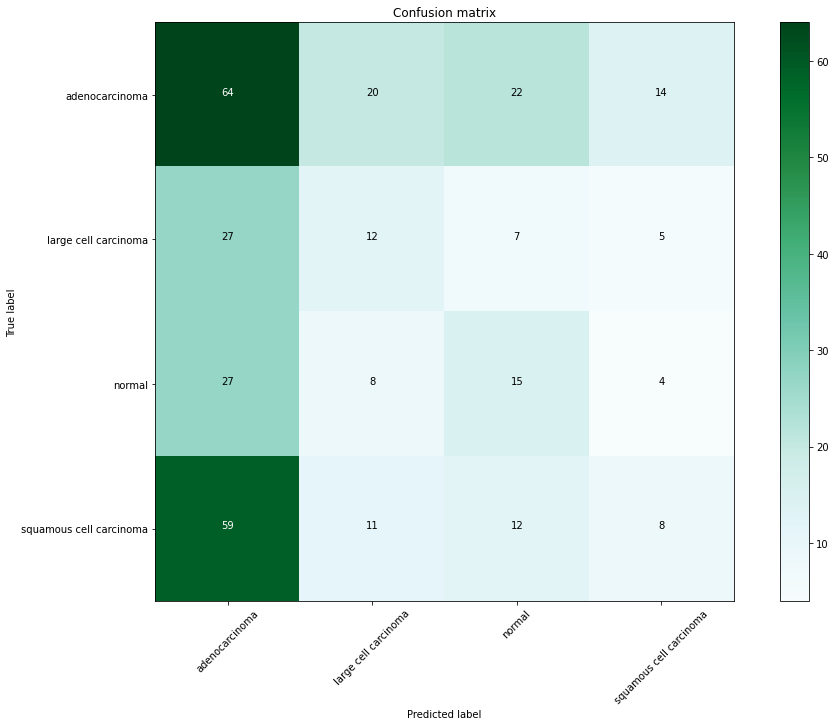

In [ ]:
from mlxtend.plotting import plot_confusion_matrix

cm_plot_labels = ['adenocarcinoma', 'large cell carcinoma', 'normal', 'squamous cell carcinoma']
cm = confusion_matrix(y_true= y_test_al, y_pred=rounded_predictions_al)

plt.figure(figsize=(14, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.BuGn)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(cm_plot_labels))
plt.xticks(tick_marks, cm_plot_labels, rotation=45)
plt.yticks(tick_marks, cm_plot_labels)

print(cm)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')



---


# 8 - Entrainer le modèle AlexNet version 2

##8.1 - Entrainer AlexNet version 2

In [ ]:
# Building Model

#num_classes = len(class_names)    #ici 4

model_alexnet_2 = Sequential([ 
  layers.Rescaling(1./255, input_shape=(227, 227, 3)),
  layers.Conv2D(96, 11, strides=(4, 4), activation='relu'), 
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size =(3, 3),strides=(2, 2)),

  layers.Conv2D(256, 5, padding="same", activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(  strides=(2, 2)),

  layers.Conv2D(384, 3,padding="same", activation='relu'),
  layers.BatchNormalization(),

  layers.Conv2D(384, 3,padding="same", activation='relu'),
  layers.BatchNormalization(),

  layers.Conv2D(256, 3,padding="same",activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size =(3, 3), strides=(2, 2)),
  layers.Activation('relu'),

  layers.Flatten(),

  layers.Dense(4096, activation='relu'),
  layers.BatchNormalization(),
  layers.Dropout(0.4),                                                       #permet d'éviter l'overfitting, va supprimer 40% des neurones
  
  layers.Dense(4096, activation='relu'),
  layers.BatchNormalization(),
  layers.Dropout(0.4),  
  
  layers.Dense(4, activation='softmax')  
])

model_alexnet_2.compile(
  optimizer= tf.keras.optimizers.SGD(lr=0.00001, momentum=0.9),        
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),  
  metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
model_alexnet_2.summary() 

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_25 (Rescaling)    (None, 227, 227, 3)       0         
                                                                 
 conv2d_112 (Conv2D)         (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization_64 (Bat  (None, 55, 55, 96)       384       
 chNormalization)                                                
                                                                 
 max_pooling2d_72 (MaxPoolin  (None, 27, 27, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_113 (Conv2D)         (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_65 (Bat  (None, 27, 27, 256)    

In [ ]:
history_alexnet_2= model_alexnet_2.fit(
  train_ds,
  validation_data=valid_ds,
  epochs= 100
)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history_alexnet_2.history['accuracy']
val_acc = history_alexnet_2.history['val_accuracy']
loss = history_alexnet_2.history['loss']
val_loss = history_alexnet_2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.ylim(0,1)
plt.figure()

plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.ylim(0,1.5)
plt.figure()

plt.show()

##8.2 - Evaluation AlexNet version 2

[[43 22 36 19]
 [17 12 15  7]
 [17  8 15 14]
 [31 27 19 13]]


Text(0.5, -17.873629022556997, 'Predicted label')

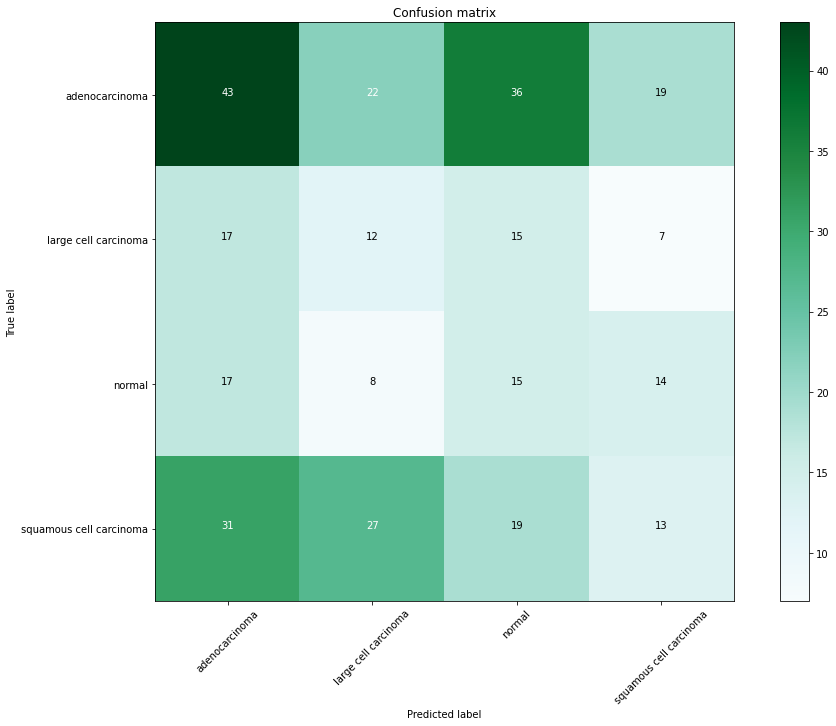

In [ ]:
from mlxtend.plotting import plot_confusion_matrix

predictions = model_alexnet_2.predict(test_ds, batch_size, verbose=0)
rounded_predictions_al = np.argmax(predictions, axis = -1)  #normaliser

y_test_al = []
for images, labels in test_ds:
  labels = np.array(labels)
  for i in labels: 
    y_test_al.append(i) 

y_test_al = np.transpose(y_test_al)

cm_plot_labels = ['adenocarcinoma', 'large cell carcinoma', 'normal', 'squamous cell carcinoma']
cm = confusion_matrix(y_true= y_test_al, y_pred=rounded_predictions_al)

plt.figure(figsize=(14, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.BuGn)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(cm_plot_labels))
plt.xticks(tick_marks, cm_plot_labels, rotation=45)
plt.yticks(tick_marks, cm_plot_labels)

print(cm)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')